### Libraries and dependencies

In [2]:
import copy
import time
import torch
import random
import allensdk
import numpy as np
from tqdm import tqdm
from hmmlearn import hmm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
#from sklearn.decomposition import PCA
#import pomegranate
#from pomegranate.hmm import DenseHMM, SparseHMM
#from pomegranate.distributions import Poisson, Normal#, ZeroInflated
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

In [ ]:
output_dir = "C:/Users/Jerry/Downloads/vbn_s3_cache"
output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)
session_id_1 = 1048189115
session_id = 1064644573 # Arbitrary pick
session = cache.get_ecephys_session(ecephys_session_id=session_id)
session_1 = session = cache.get_ecephys_session(ecephys_session_id=session_id_1)
behavior_id = session.behavior_session_id
behavior = cache.get_behavior_session(behavior_id)
sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block'] == 0]

In [ ]:
print(dir(cache))

In [ ]:
session_day_2 = 1064644573


In [160]:
units = session.get_units()
channels = session.get_channels()
spike_times = session.spike_times
unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)


unit_channels_filtered = unit_channels[(unit_channels.isi_violations < 0.5) &
                                      (unit_channels.presence_ratio > 0.9) &
                                      (unit_channels.amplitude_cutoff < 0.1) &
                                      (unit_channels.firing_rate > 0.1)]
units_vision = np.array(list(unit_channels_filtered[(unit_channels_filtered['structure_acronym']=='VISp') |
                                                   (unit_channels_filtered['structure_acronym']=='VISpm') |
                                                   (unit_channels_filtered['structure_acronym']=='VISrl') |
                                                   (unit_channels_filtered['structure_acronym']=='VISl') |
                                                   (unit_channels_filtered['structure_acronym']=='VISam') |
                                                   (unit_channels_filtered['structure_acronym']=='VISal')].index))
unit_channels_indices = units_vision
print(len(unit_channels_indices))

271


In [5]:
# Obtain the last active stimulus
stim = session.stimulus_presentations
active_stim = stim[stim.active == True]
print(np.max(active_stim.start_time))

3627.160882819599


### Data Processing and Helper Functions

In [168]:
# Obtain binned neuron spikings
# Start, stop are in seconds and bin_size is in ms
def getX(start, stop, bin_size):
    if (stop < 0 or start < 0):
        return -1
    time = stop - start
    bin_count = int(time * 1000 / bin_size)
    X = np.zeros(bin_count)
    for unit in tqdm(unit_channels_indices):
        # Dividing epochs
        raw_spikes = spike_times[unit]
        bins = np.linspace(start,stop,num=bin_count+1)
        x_1 = np.histogram(raw_spikes, bins=bins)[0].tolist()
        #x_1 = np.array(stats.zscore(x_1))
        X = np.vstack((X, x_1))
    X = np.delete(X, 0, 0)
    return X

# Plot a raster plot for binned neuron spikings
def raster(X):
    plt.figure(figsize=(20,10))
    raster_pos = {}
    for idx, row in enumerate(X):
        raster_pos[idx] = np.where(row==1)[0]
    raster_pos = raster_pos.values()
    plt.eventplot(raster_pos,linelengths=1,linewidths=1);

# Transform counts in each bin to only 1, randomly allocate 1 when no activities
def one_per_bin(X):
    X_1 = X.astype(bool).astype(int)
    for idx, bin in enumerate(X_1):
        if (np.sum(bin) > 1):
            new_bin = np.zeros(len(bin))
            random_neuron = np.random.choice(np.arange(0,len(bin)),1)
            new_bin[random_neuron] = 1
            X_1[idx] = new_bin
    return X_1

# Not used
def between_stimulus(session, trial_idx, bin_size, window):
    # Getting all the trials
    trials = session.trials
    # Only the ones that changed
    trials_change = trials[trials['is_change']]
    trial = trials_change.iloc[trial_idx]
    change_time = trial['change_time_no_display_delay']
    change_from = trial['initial_image_name']
    change_to = trial['change_image_name']

    # start and end in seconds
    start = change_time - window
    end = change_time + window
    X = getX(start, end, bin_size)
    x_axis = np.arange(- window * 1000, window * 1000+1, step=int(bin_size * 5))
    ticks = np.arange(0, 2 * window * 1000 + 1, step = int(bin_size * 5))
    return X.T, [change_from, change_to], x_axis, ticks

# Testing function to manually check prediction and stimulus
def display_stim(session):
    dictionary = {}
    trials = session.trials
    trials_idx = trials[(trials['start_time']>50) & (trials['stop_time']<650)].index
    for idx in trials_idx:
        trial = session.trials.loc[idx]
        change_from = trial['initial_image_name']
        change_to = trial['change_image_name']
        change_at = trial['change_time_no_display_delay']
        trial_start = trial['start_time']
        trial_end = trial['stop_time']
        if (change_from not in dictionary):
            dictionary[change_from] = 0
        dictionary[change_from] += 1
        if (change_to not in dictionary):
            dictionary[change_to] = 0
        dictionary[change_to] += 1
        #print('start: {}({}) |{}| {}({})'.format(change_from, trial_start, change_at, change_to,trial_end))
        if (len(list(dictionary.keys()))==8):
            continue
            #break
    return dictionary

# Obtaining histograms that shows the stimulus distribution for each hidden state
# Not in use, use states_per_img() instead
def get_states_histogram(start, end, bin_size, predictions):
    sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block']==0]
    stimulus_presentation_id = 0
    is_change = sp.loc[0]['is_change']
    counts_unchanged = {}
    counts_hit = {}
    counts_miss = {}
    
    stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
    stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
    unique_stimuli = np.append(np.unique(sp['image_name']), "gray")
    unique_preds = np.unique(predictions)

    all_states = {}
    for pred in unique_preds:
        all_states[pred] = 0
    for stimulus in unique_stimuli:
        counts_unchanged[stimulus] = copy.deepcopy(all_states)
    counts_hit = copy.deepcopy(counts_unchanged)
    counts_miss = copy.deepcopy(counts_unchanged)
        
    for idx, pred in enumerate(predictions):
        bin_start_time = float(start + (bin_size / 1000) * idx)
        # Bin before stimulus: gray screen
        if (bin_start_time < stimulus_start_time):
            stimulus_name = "gray"
        # Bin after stimulus: gray screen, move to the next stimulus
        elif (bin_start_time > stimulus_end_time):
            stimulus_presentation_id += 1
            stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
            stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
            is_change = sp.loc[stimulus_presentation_id]['is_change']
            if (bin_start_time < stimulus_start_time):
                stimulus_name = "gray"
            else:
                stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
        else:
            stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
            
        if not is_change:
            counts_unchanged[stimulus_name][pred] += 1
        else:
            hit = sp.loc[stimulus_presentation_id]['rewarded']
            if hit:
                counts_hit[stimulus_name][pred] += 1
            else:
                counts_miss[stimulus_name][pred] += 1
    return counts_unchanged, counts_hit, counts_miss

# Assign hidden states to each image
def states_per_img(start, end, bin_size, predictions):
    sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block'] == 0]
    # dictionary for each pred
    unique_preds = np.unique(predictions)
    states = {str(state): 0 for state in unique_preds}
    # dictionary for unchange, hit, miss
    unique_stimuli = np.unique(sp['image_name'])
    unchanged = {stimulus: copy.deepcopy(states) for stimulus in unique_stimuli}
    gray = copy.deepcopy(states)
    hit = copy.deepcopy(unchanged)
    miss = copy.deepcopy(unchanged)
    # The initial stimulus info
    stimulus_presentation_id=sp[sp['start_time'] <= start].index[-1]
    #is_change = sp.loc[stimulus_presentation_id]['is_change']
    #hit = sp.loc[stimulus_presentation_id]['rewarded']
    stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
    stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
    
    for idx, pred in enumerate(predictions):
        bin_start_time = float(start + (bin_size / 1000) * idx)
        stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
        is_change = sp.loc[stimulus_presentation_id]['is_change']
        is_hit = sp.loc[stimulus_presentation_id]['rewarded']
        # Bin before stimulus: gray screen
        if (bin_start_time < stimulus_start_time):
            gray[str(pred)] += 1
            continue
        # Bin after stimulus: gray screen, move to the next stimulus
        elif (bin_start_time > stimulus_end_time):
            stimulus_presentation_id += 1
            stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
            stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
            gray[str(pred)] += 1
            continue
        if not is_change:
            unchanged[stimulus_name][str(pred)] += 1
        else:
            if is_hit:
                hit[stimulus_name][str(pred)] += 1
            else:
                miss[stimulus_name][str(pred)] += 1
    return unchanged, hit, miss, gray
    
# Shows the hidden state distribution for each image stimulus and gray screen
def stimulus_state_dist(unchanged, hit, miss, gray):
    fig, axs = plt.subplots(len(unchanged)+1,3, figsize=(24,40))
    # Stimulus -> States
    for idx, each in enumerate(unchanged.keys()):
        states = list(unchanged[each].keys())
        unchanged_val = list(unchanged[each].values())
        hit_val = list(hit[each].values())
        miss_val = list(miss[each].values())
        axs[idx][0].bar(states, unchanged_val)
        axs[idx][1].bar(states, hit_val)
        axs[idx][2].bar(states, miss_val)
        axs[idx][0].set_title(str(each))
        axs[idx][1].set_title('hit')
        axs[idx][2].set_title('miss')
    states = list(gray.keys())
    gray_val = list(gray.values())
    axs[-1][0].bar(states, gray_val)
    axs[-1][0].set_title('gray')

# Find and plot Euclidean distance across unchanged, hit, and miss trials
def stimulus_state_diff(unchanged, hit, miss, gray):
    # For each hidden state
    u = np.zeros(len(unchanged.keys()))
    h = copy.deepcopy(u)
    m = copy.deepcopy(u)
    gh = copy.deepcopy(u)
    gm = copy.deepcopy(u)
    gd = copy.deepcopy(u)
    for idx, stimulus in enumerate(unchanged.keys()):
        # Preprocess into ratios
        unchanged_each = list(unchanged[stimulus].values())
        unchanged_total = np.sum(unchanged_each) if np.sum(unchanged_each) > 0 else 1e-10
        unchanged_ratio = np.array(unchanged_each)/unchanged_total    
        hit_each = list(hit[stimulus].values())
        hit_total = np.sum(hit_each) if np.sum(hit_each) > 0 else 1e-10
        hit_ratio = np.array(hit_each)/hit_total
        miss_each = list(miss[stimulus].values())
        miss_total = np.sum(miss_each) if np.sum(miss_each) > 0 else 1e-10
        miss_ratio = np.array(miss_each)/miss_total
        gray_each = list(gray.values())
        gray_total = np.sum(gray_each) if np.sum(gray_each) > 0 else 1e-10
        gray_ratio = np.array(gray_each)/gray_total
        # Distance of baseline
        u[idx] = np.linalg.norm(unchanged_ratio)
        # Distance of hit w/ unchanged
        h[idx] = np.linalg.norm(unchanged_ratio - hit_ratio)
        # Distance of miss w/ unchanged
        m[idx] = np.linalg.norm(unchanged_ratio - miss_ratio)
        # Distance of hit w/ gray
        gh[idx] = np.linalg.norm(gray_ratio - hit_ratio)
        # Distance of miss w/ gray
        gm[idx] = np.linalg.norm(gray_ratio - miss_ratio)
        # Bar plot of difference between the two
        gd[idx] = np.abs(gh[idx] - gm[idx])

    plt.figure(figsize=(20,10))
    #plt.plot(u, label='baseline')
    plt.plot(h, label='hit')
    plt.plot(m, label='miss')
    plt.plot(gh, label='hit w/ gray')
    plt.plot(gm, label='miss w/ gray')
    plt.bar(np.arange(0,len(unchanged.keys())), gd, alpha=0.3)
    plt.xticks(ticks=np.arange(0,len(unchanged.keys())), labels=[str(each) for each in list(unchanged.keys())], label="diff between hit w/ gray and miss w/ gray")
    plt.legend()

"""
def states_per_img_og(start, end, bin_size, predictions):
    sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block'] == 0]
    unique_stimuli = np.append(np.unique(sp['image_name']), "gray")
    stimulus_presentation_id=sp[sp['start_time'] < start].index[-1]
    is_change = sp.loc[stimulus_presentation_id]['is_change']
    hit = sp.loc[stimulus_presentation_id]['rewarded']
    unique_preds = np.unique(predictions)
    counts_unchanged = {}
    counts_hit = {}
    counts_miss = {}
    all_imgs = {}
    stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
    stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']

    for stimulus in unique_stimuli:
        all_imgs[stimulus] = 0
    for pred in unique_preds:
        counts_unchanged[pred] = copy.deepcopy(all_imgs)
    counts_hit = copy.deepcopy(counts_unchanged)
    counts_miss = copy.deepcopy(counts_unchanged)

    for idx, pred in enumerate(predictions):
        bin_start_time = float(start + (bin_size / 1000) * idx)
        stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
        is_change = sp.loc[stimulus_presentation_id]['is_change']
        # Bin before stimulus: gray screen
        if (bin_start_time < stimulus_start_time):
            stimulus_name = "gray"
            is_change=False
        # Bin after stimulus: gray screen, move to the next stimulus
        elif (bin_start_time > stimulus_end_time):
            stimulus_presentation_id += 1
            stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
            stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
            if (bin_start_time < stimulus_start_time):
                stimulus_name = "gray"
                is_change=False
        if not is_change:
            counts_unchanged[pred][stimulus_name] += 1
        else:
            hit = sp.loc[stimulus_presentation_id]['rewarded']
            if hit:
                counts_hit[pred][stimulus_name] += 1
            else:
                counts_miss[pred][stimulus_name] += 1
    return counts_unchanged, counts_hit, counts_miss

def train(X, n, iters, jobs):
    start = default_timer()
    model = pomegranate.HiddenMarkovModel.from_samples(PoissonDistribution, n_components=n, X=X, min_iterations=iters, max_iterations=iters, n_jobs=jobs)
    hidden_states = model.viterbi(X_test)[1]
    #print(", ".join(state.name for i, state in hidden_states2))
    duration = default_timer() - start
    arr = np.zeros(len(hidden_states))
    for idx, each_bin in enumerate(hidden_states):
        arr[idx] = each_bin[0]
    uni, counts = np.unique(arr, return_counts=True)
    return duration, uni, counts

def train_cuda(X, iters, X_test, n):
    print(X.size())
    print(X_test.size())
    start = default_timer()
    model = DenseHMM([Poisson().cuda()]*n, verbose=True, max_iter=iters).cuda()
    print("Model created")
    print(model.fit(X.cuda()).cuda())
    print("Model fit to data")
    hidden_states = model.predict(X_test.cuda()).cuda()
    return hidden_states
    print("Model predicted")
    print(hidden_states[0])
    #print(", ".join(state.name for i, state in hidden_states2))
    duration = default_timer() - start
    arr = np.zeros(len(hidden_states))
    for idx, each_bin in enumerate(hidden_states[0]):
        arr[idx] = each_bin
    uni, counts = np.unique(arr, return_counts=True)
    return duration, uni, counts,hidden_states
""";

### Model Selection

In [ ]:
X_train = getX(50,3550,50).T
# train on the entire dataset
iters = 1
ns = np.arange(4,404,100)
aic = np.zeros([len(ns),iters])
bic = np.zeros([len(ns),iters])
ll =  np.zeros([len(ns),iters])
for idx, n in tqdm(enumerate(ns)):
    for i in range(iters):
        model = hmm.PoissonHMM(n_components=n, n_iter=1000, verbose=True, tol=10)
        model.fit(X_train)
        aic[idx][i] = model.aic(X_train)
        bic[idx][i] = model.bic(X_train)
        ll[idx][i] = model.score(X_train)

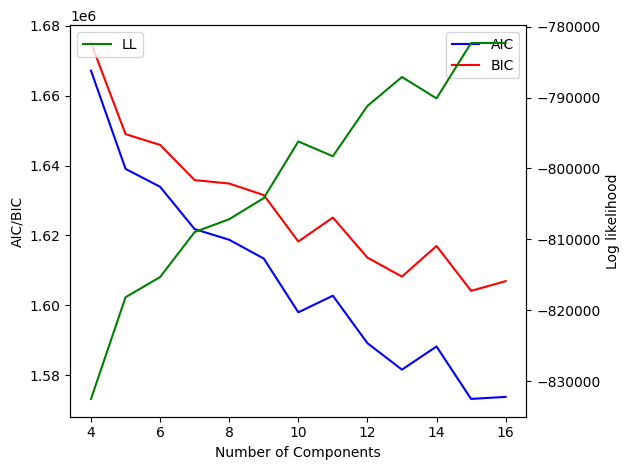

In [ ]:
fig, ax = plt.subplots()
ln1 = ax.plot(ns, np.mean(aic,axis=1), color='blue', label="AIC")
ln2 = ax.plot(ns, np.mean(bic,axis=1), color='red', label="BIC")
ax.legend()
ax2 = ax.twinx()
ln3 = ax2.plot(ns, np.mean(ll,axis=1), color='green', label="LL")
ax.set_ylabel("AIC/BIC")
ax2.set_ylabel("Log likelihood")
ax.set_xlabel("Number of Components")
ax2.legend()
fig.tight_layout()
plt.show()

### To make sure HMM works

In [296]:
def generate_distinct_colors(n):
    colors = plt.cm.get_cmap('turbo', n)
    return [colors(i)[:3] for i in range(n)]
def visualize_prediction(start, end, target_start, target_end, bin_size, lambdas):
    bin_size /= 1000 # ms to s
    # Getting the closest time bins based on desired start and end time
    target_start_idx = int((target_start - start) / bin_size)
    target_start = start + bin_size * target_start_idx
    target_end_idx = int((target_end - start) / bin_size)
    target_end = start + bin_size * target_end_idx
    # Get the corresponding lambdas
    truncated_lambdas = lambdas[target_start_idx:target_end_idx]
    # Plot the states (lambdas)
    plt.figure(figsize=(40,20))
    plt.plot(np.arange(target_start, target_end-1e-5, bin_size), truncated_lambdas, ".-", mfc="orange");
    # Obtain the corresponding stimuli
    start_idx = list(sp[sp['start_time']>target_start].index)[0]
    end_idx = list(sp[sp['start_time']<target_end].index)[-1]
    unique_stimuli = np.unique(sp.loc[start_idx:end_idx]['image_name'])
    color = generate_distinct_colors(len(unique_stimuli))
    colors = {unique_stimuli[idx]: color[idx] for idx, each in enumerate(unique_stimuli)}
    labeled = {each: False for each in unique_stimuli} # Label stimulus color just once
    # Color based on each stimulus
    for i in range(start_idx, end_idx+1, 1):
        start_time = sp.loc[i]['start_time']
        end_time = sp.loc[i]['end_time']
        image_name = sp.loc[i]['image_name']
        if not labeled[image_name]:
            plt.axvspan(start_time, end_time, color=colors[image_name], alpha=0.3, label=image_name)
            labeled[image_name] = True
        else:
            plt.axvspan(start_time, end_time, color=colors[image_name], alpha=0.3)
    plt.legend()

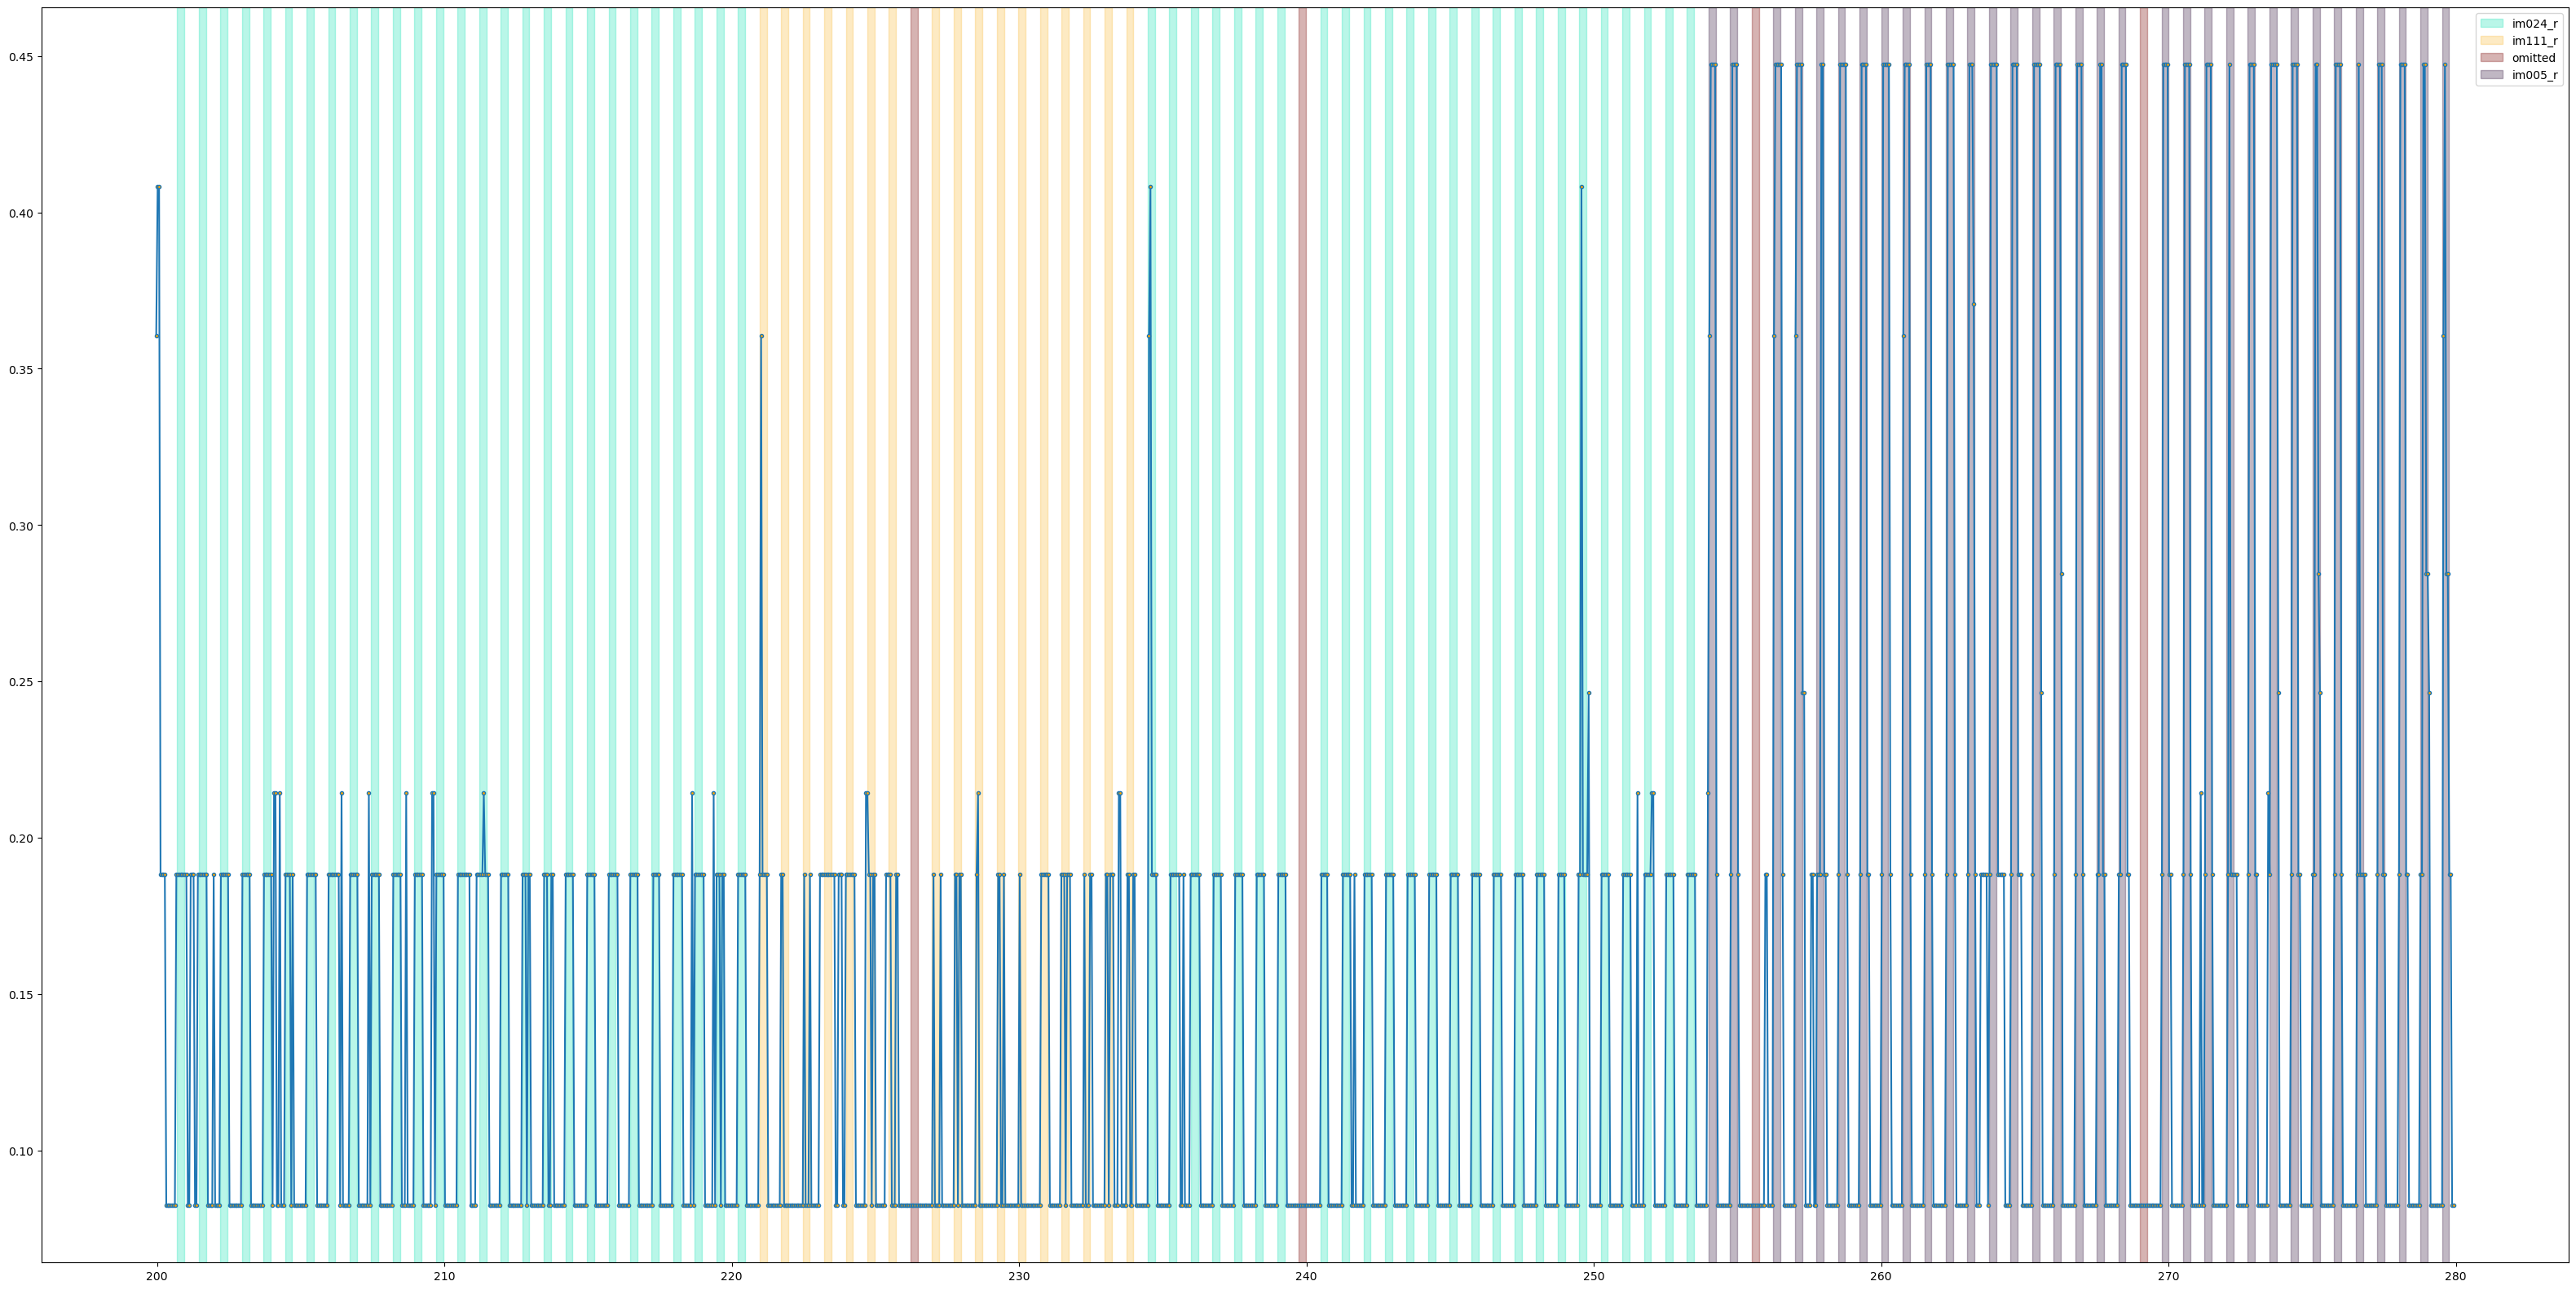

In [297]:
lambdas = np.mean(model.lambdas_[preds], axis = 1)
bin_size = 50
visualize_prediction(start_time, end_time, 200, 280, bin_size, lambdas)

### Hidden state distribution for each img

In [264]:
start_time = sp.iloc[0]['start_time']
end_time = sp.iloc[-1]['end_time']
bin_size = 50
X_train = getX(start_time,end_time,bin_size).T
model = hmm.PoissonHMM(n_components=13, n_iter=1000, tol=10, verbose=True)
model.fit(X_train)
preds = model.predict(X_train)
unchanged, hit, miss, gray = states_per_img(start_time, end_time, bin_size, preds)

100%|██████████| 271/271 [00:12<00:00, 22.19it/s]
         1 -27193606.58834054             +nan
         2 -9203570.26755248 +17990036.32078806
         3 -8771360.18431306 +432210.08323942
         4 -8670238.16439980 +101122.01991326
         5 -8635160.55058152  +35077.61381828
         6 -8616653.32946978  +18507.22111174
         7 -8603583.20876253  +13070.12070725
         8 -8594293.82868017   +9289.38008236
         9 -8587167.13334449   +7126.69533568
        10 -8581883.84955885   +5283.28378564
        11 -8578280.69953321   +3603.15002563
        12 -8575097.90108409   +3182.79844913
        13 -8572434.87671400   +2663.02437009
        14 -8570634.15469152   +1800.72202248
        15 -8569190.47432364   +1443.68036788
        16 -8567920.94016325   +1269.53416039
        17 -8567279.02510954    +641.91505371
        18 -8566972.22235037    +306.80275916
        19 -8566760.70754970    +211.51480067
        20 -8566589.35271920    +171.35483050
        21 -8566465.4908751

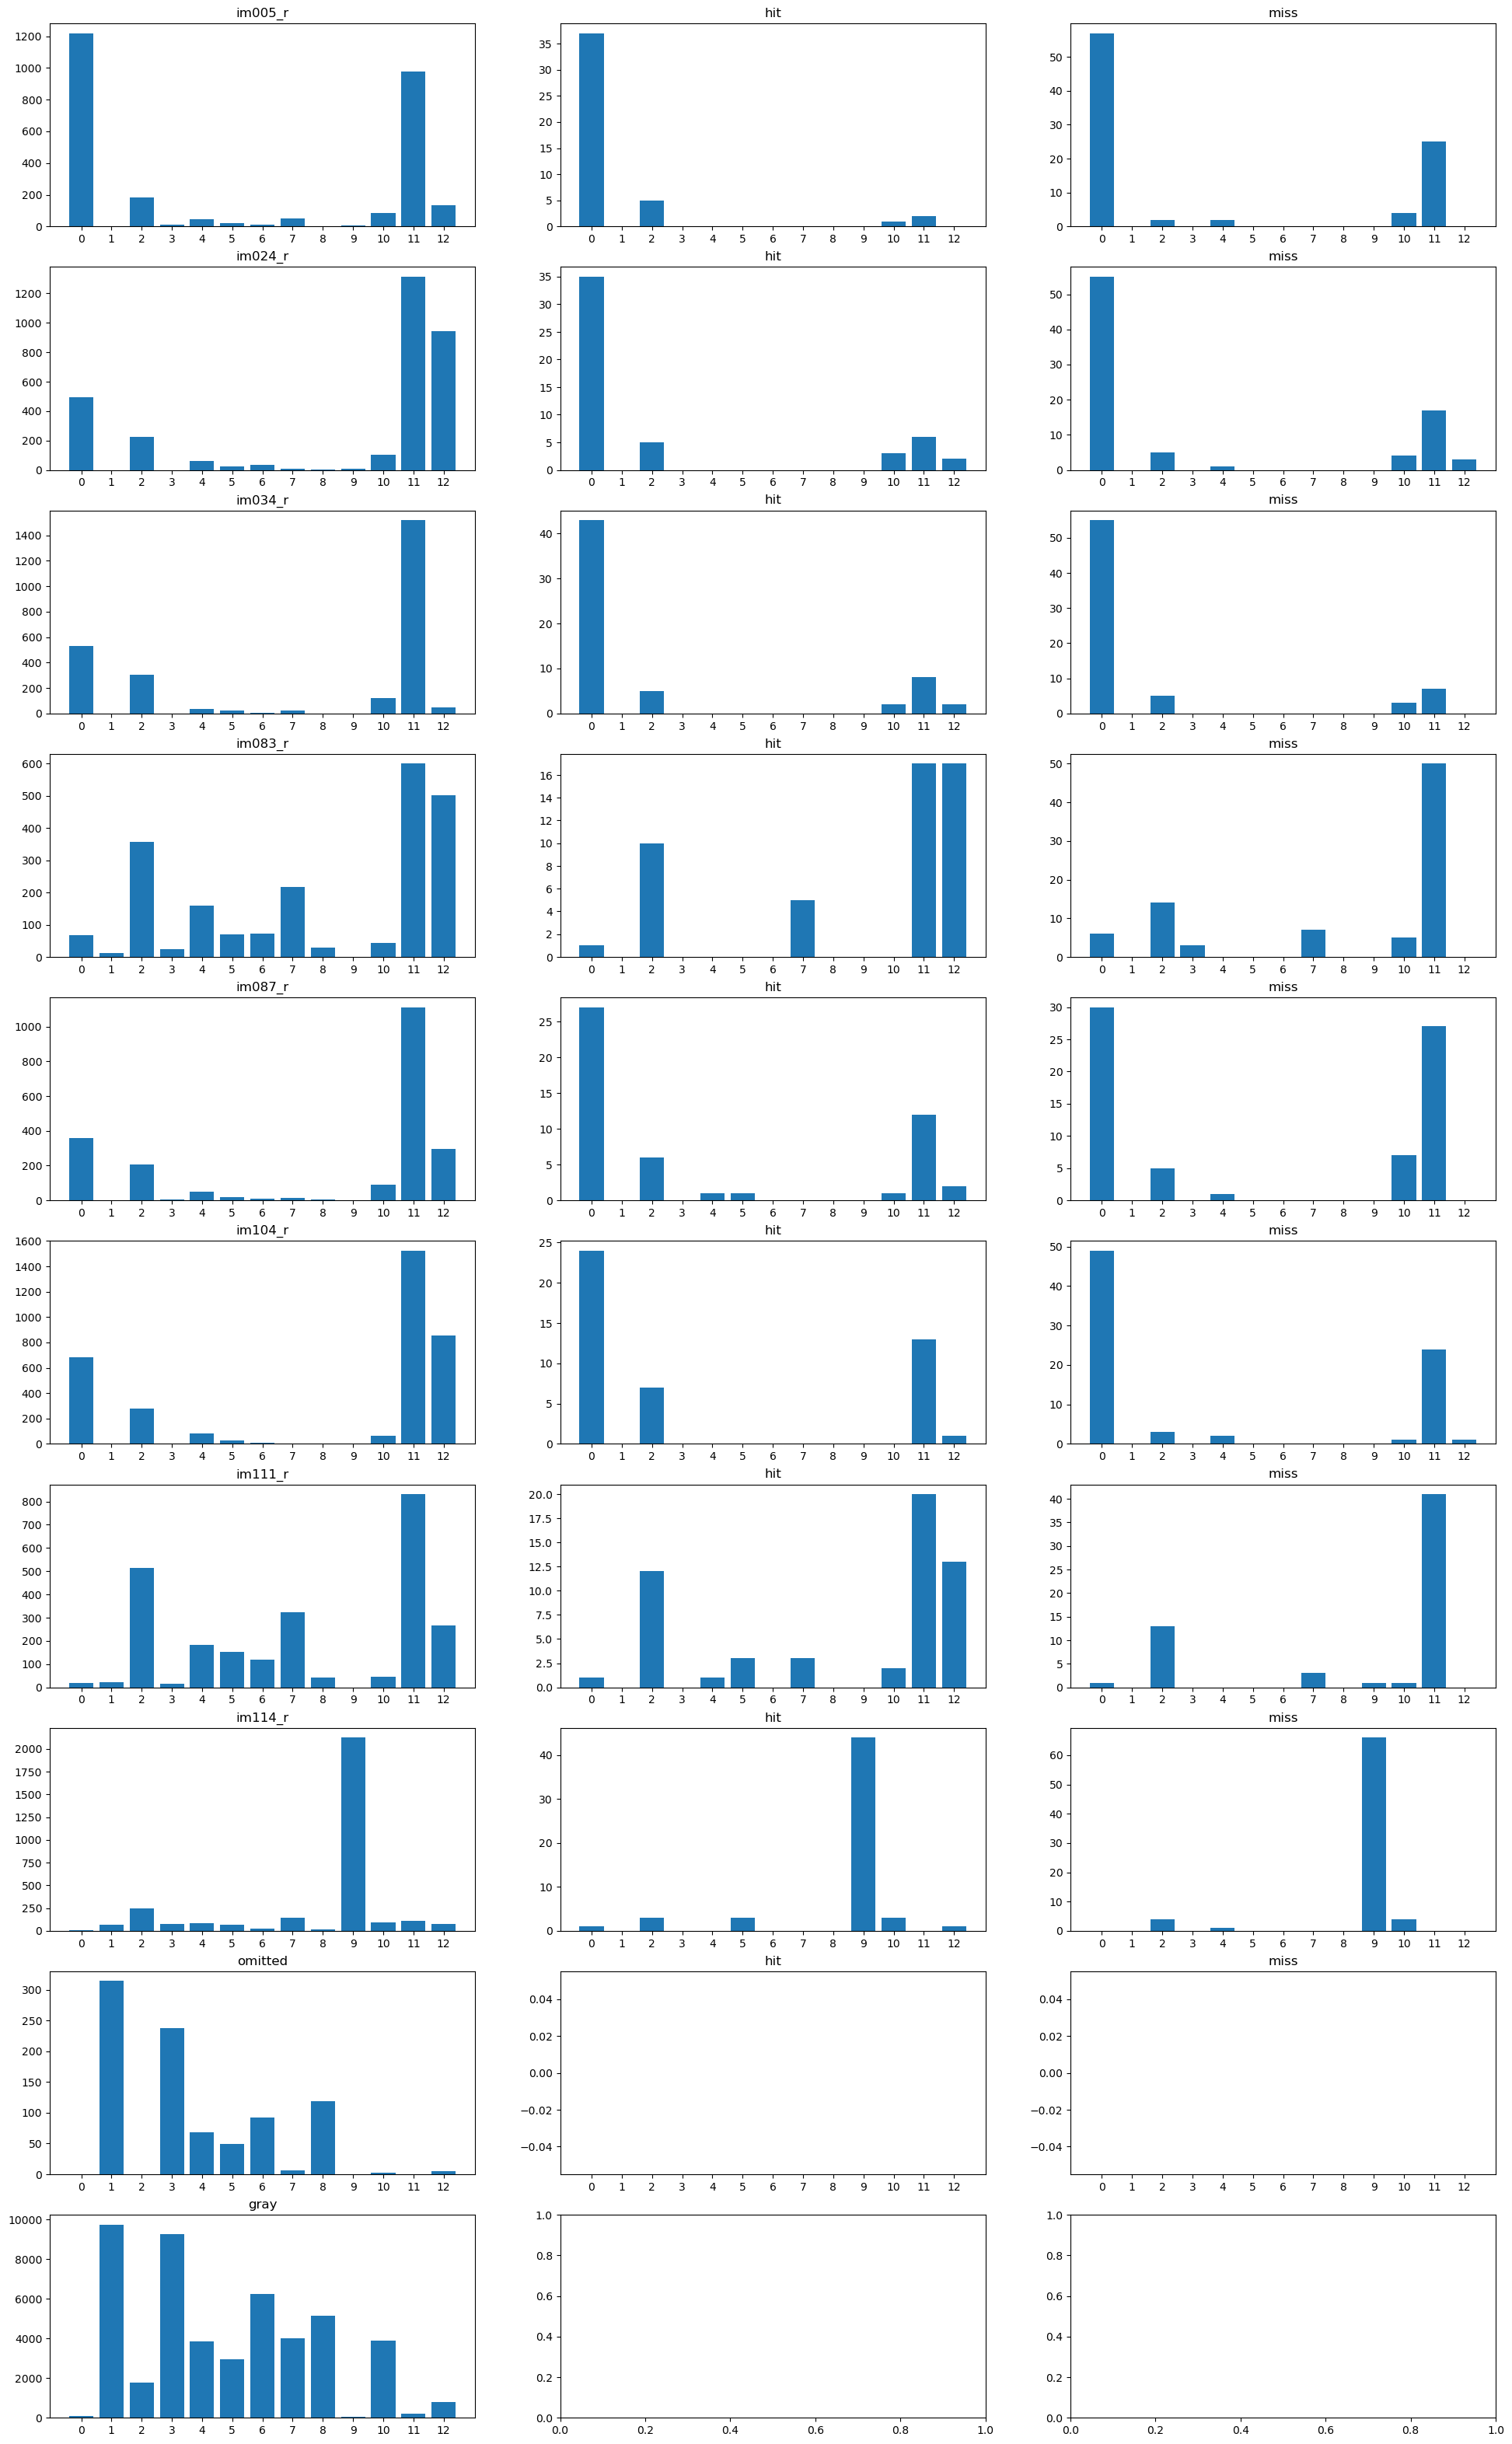

In [169]:
unchanged, hit, miss, gray = states_per_img(start_time, end_time, bin_size, preds)
stimulus_state_dist(unchanged, hit, miss, gray)

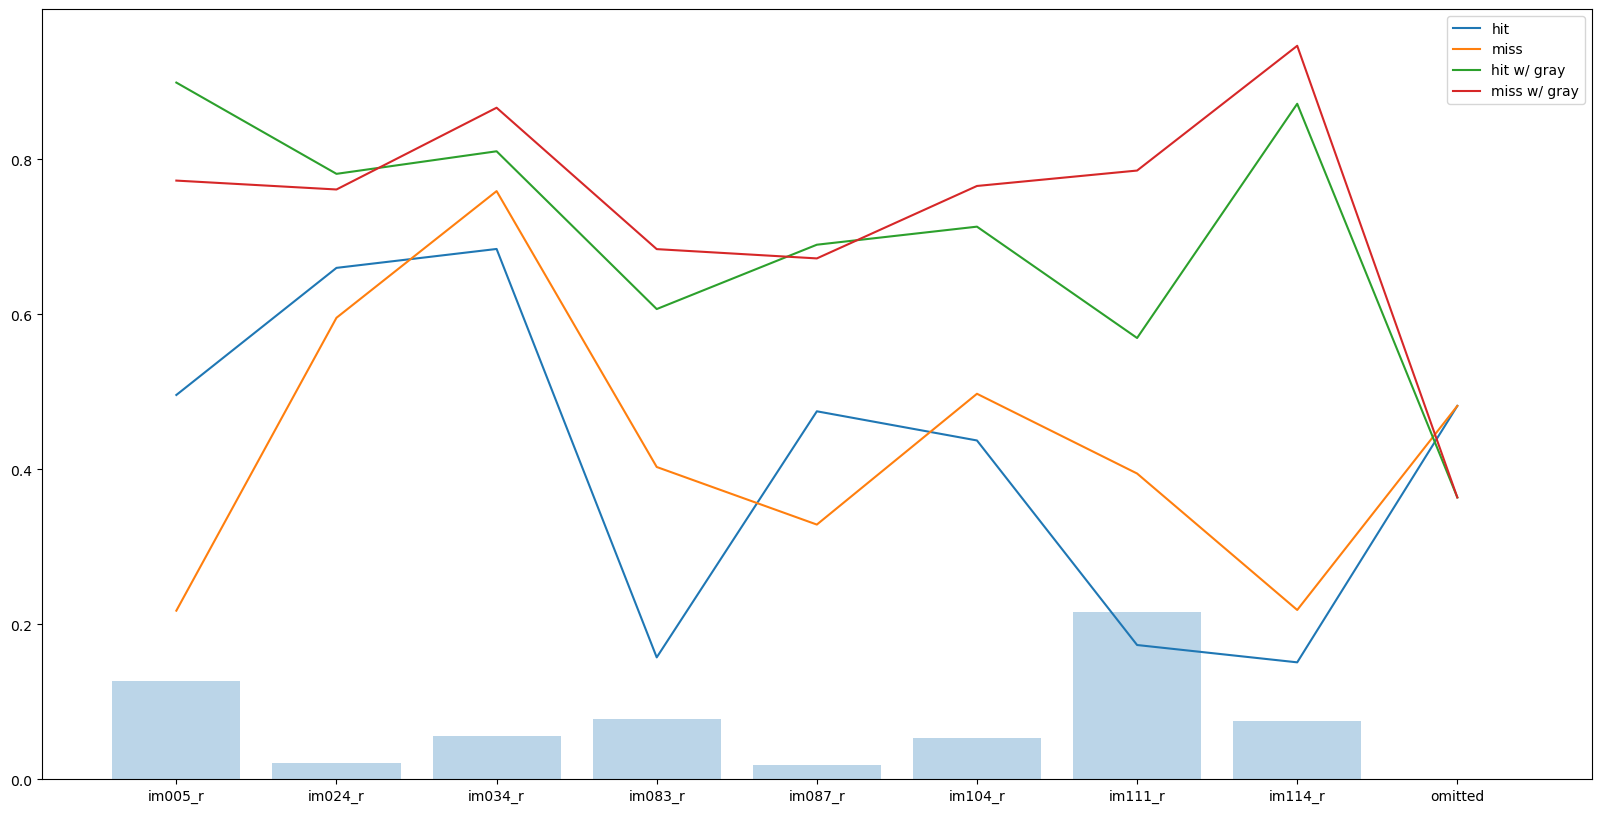

In [170]:
stimulus_state_diff(unchanged, hit, miss, gray)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=50, n_jobs=-1).fit_transform(X_train)




In [ ]:
# Getting the lambdas and apply tSNE to them 

### Img distribution for each hidden state

In [ ]:
start_time = 50
end_time = 1050
bin_size = 50
X_train = getX(start_time,end_time,bin_size).T
model_hmmlearn = hmm.PoissonHMM(n_components=13, n_iter=1000, tol=10, verbose=True, implementation='log')
model_hmmlearn.fit(X_train)
preds = model_hmmlearn.predict(X_train)

100%|████████████████████████████████████████████████████████████████████████████████| 271/271 [00:03<00:00, 79.49it/s]
         1 -7541543.37264636             +nan
         2 -2028791.57118401 +5512751.80146235
         3 -1892752.40891766 +136039.16226636
         4 -1867598.25777432  +25154.15114334
         5 -1856826.00163253  +10772.25614178
         6 -1850080.13344157   +6745.86819097
         7 -1845509.58680047   +4570.54664110
         8 -1842115.97124771   +3393.61555276
         9 -1839524.06832143   +2591.90292628
        10 -1837351.74968339   +2172.31863804
        11 -1835621.99294042   +1729.75674297
        12 -1834530.14785222   +1091.84508821
        13 -1833734.25246915    +795.89538307
        14 -1833156.98219560    +577.27027355
        15 -1832776.57290403    +380.40929157
        16 -1832481.20201826    +295.37088577
        17 -1832174.78925851    +306.41275975
        18 -1831868.94836642    +305.84089209
        19 -1831607.97822124    +260.97014518
     

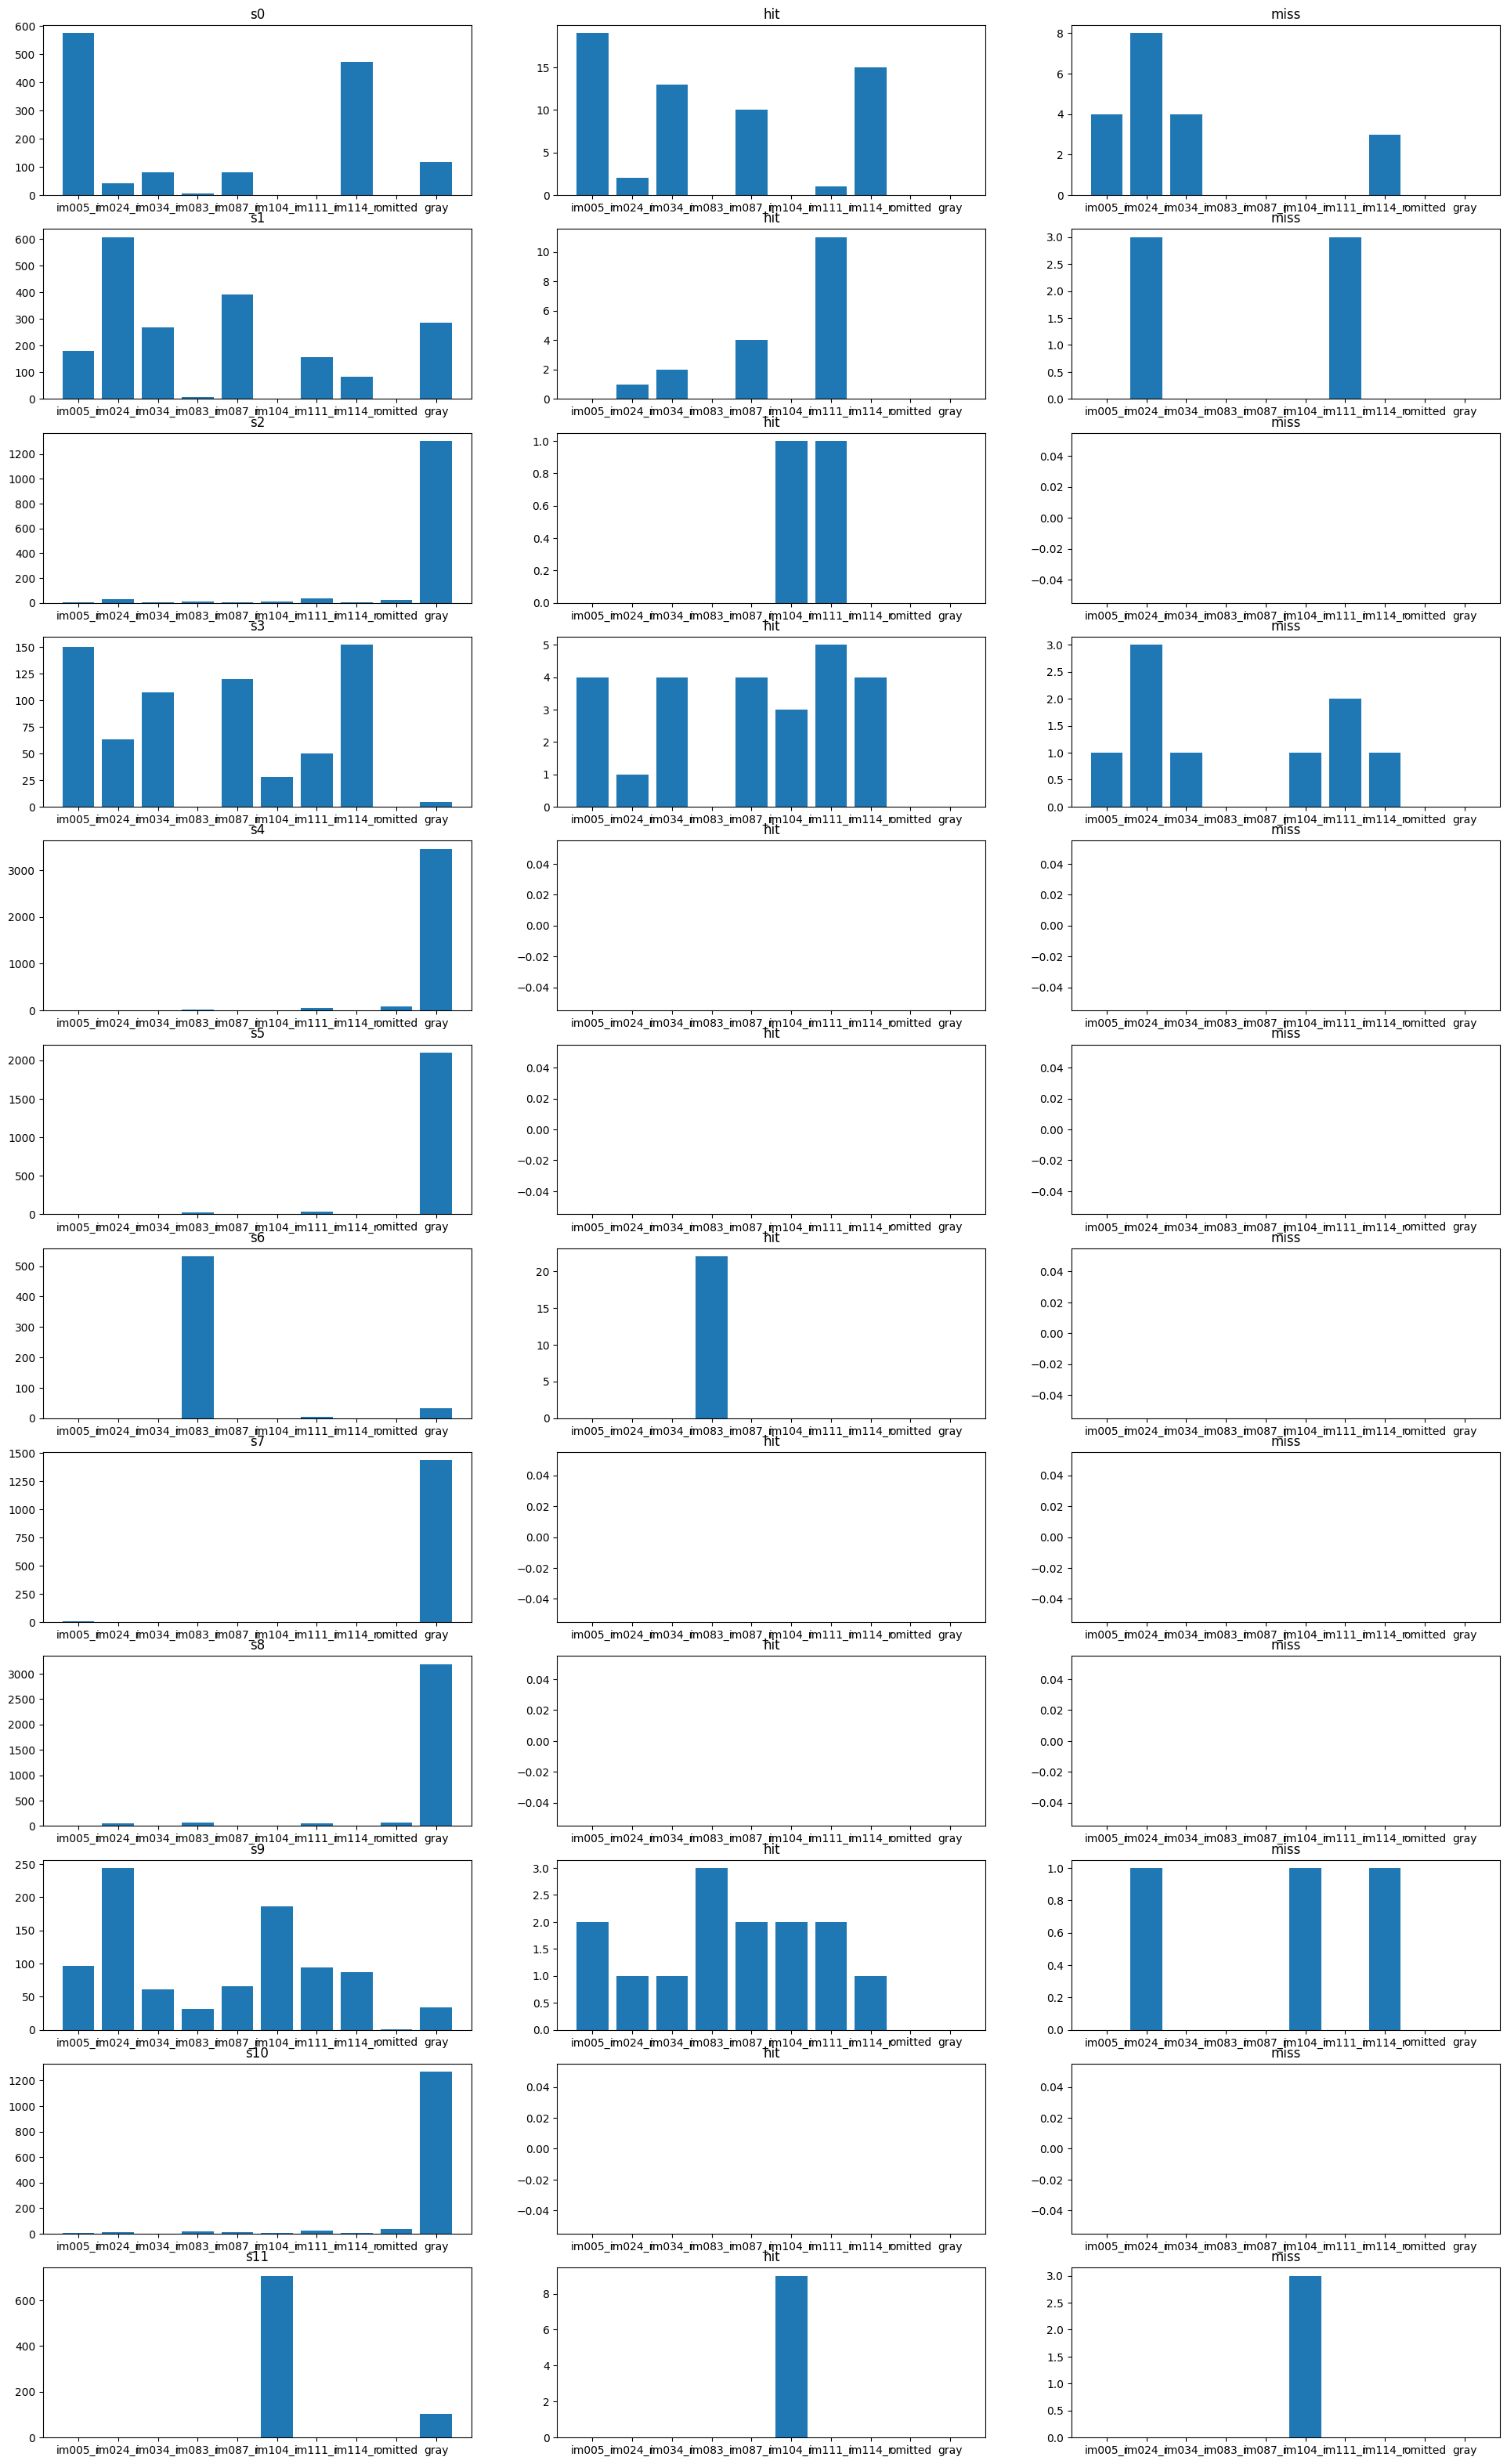

In [ ]:
#counts_unchanged, counts_hit, counts_miss = get_states_histogram(start_time,end_time,bin_size,preds)
counts_unchanged, counts_hit, counts_miss = get_img_histogram(start_time,end_time,bin_size,preds)
fig, axs = plt.subplots(len(counts_unchanged),3, figsize=(24,40))
for idx, each in enumerate(counts_unchanged.keys()):
    states = list(counts_unchanged[each].keys())
    unchanged = list(counts_unchanged[each].values())
    hit = list(counts_hit[each].values())
    miss = list(counts_miss[each].values())
    axs[idx][0].bar(states, unchanged)
    axs[idx][1].bar(states, hit)
    axs[idx][2].bar(states, miss)
    
    axs[idx][0].set_title('s'+str(each))
    axs[idx][1].set_title('hit')
    axs[idx][2].set_title('miss')

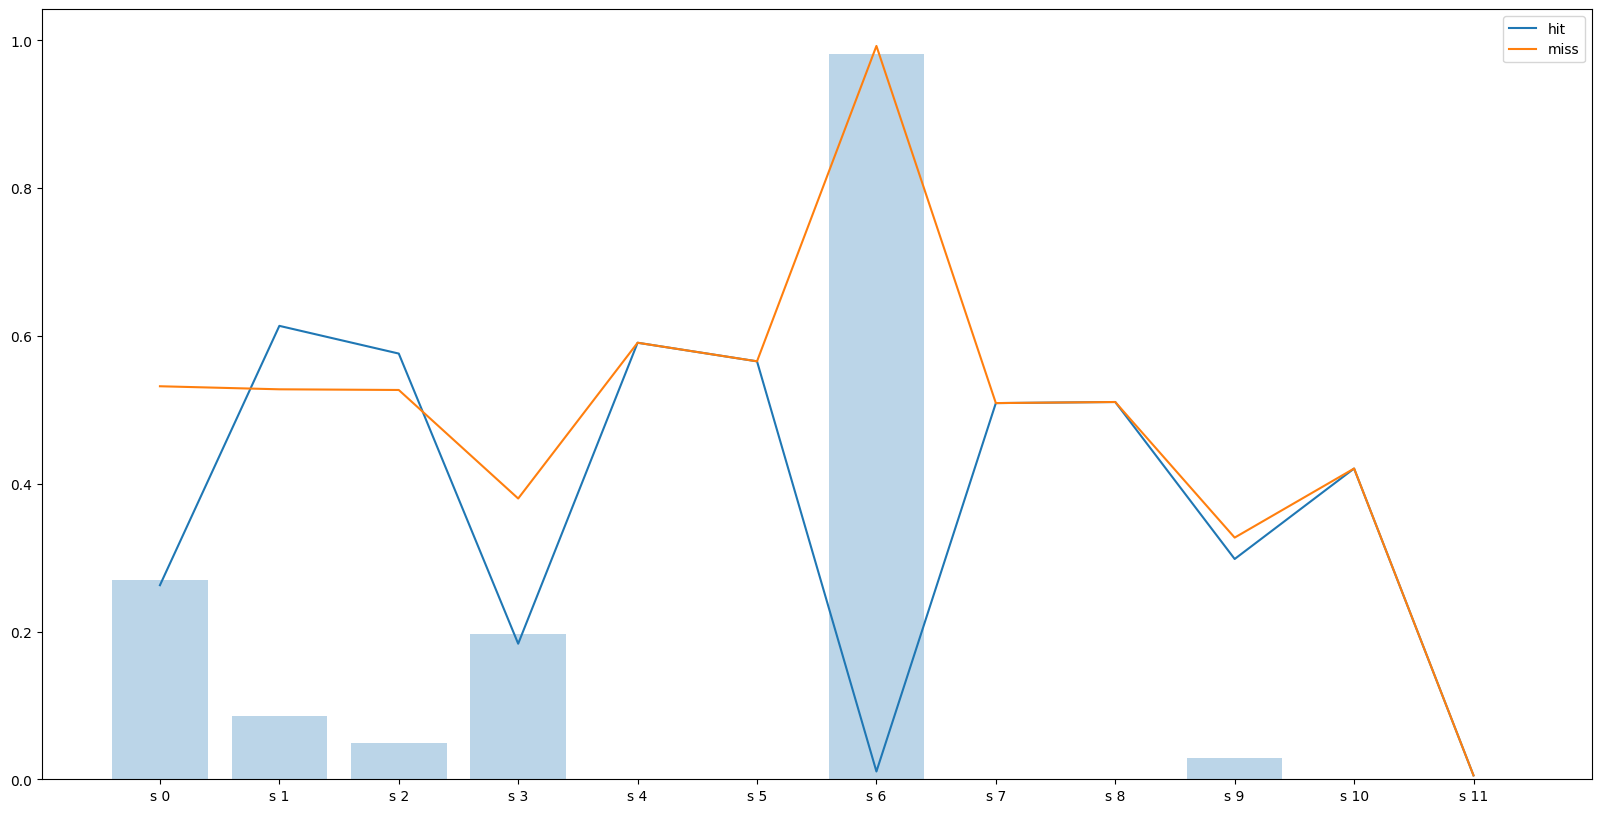

In [ ]:
u = np.zeros(len(counts_unchanged.keys()))
h = np.zeros(len(counts_unchanged.keys()))
m = np.zeros(len(counts_unchanged.keys()))
for idx, state in enumerate(counts_unchanged.keys()):
    #print(img)
    unchanged = list(counts_unchanged[state].values())[:-2]
    unchanged_total = np.sum(unchanged) if np.sum(unchanged) > 0 else 1e-10
    unchanged_img = np.array(unchanged)/unchanged_total
    
    hit = list(counts_hit[state].values())[:-2]
    hit_total = np.sum(hit) if np.sum(hit) > 0 else 1e-10
    hit_img = np.array(hit)/hit_total
    
    miss = list(counts_miss[state].values())[:-2]
    miss_total = np.sum(miss) if np.sum(miss) > 0 else 1e-10
    miss_img = np.array(miss)/miss_total
    
    #u[idx] = np.linalg.norm(unchanged_img)
    h[idx] = np.linalg.norm(unchanged_img - hit_img)
    m[idx] = np.linalg.norm(unchanged_img - miss_img)

plt.figure(figsize=(20,10))
plt.plot(h, label='hit')
plt.plot(m, label='miss')
plt.bar(np.arange(0,len(counts_unchanged.keys())), np.abs(h-m), alpha=0.3)
#plt.plot(u, label='baseline')

plt.xticks(ticks=np.arange(0,len(counts_unchanged.keys())), labels=['s '+ str(each) for each in list(counts_unchanged.keys())])
plt.legend()

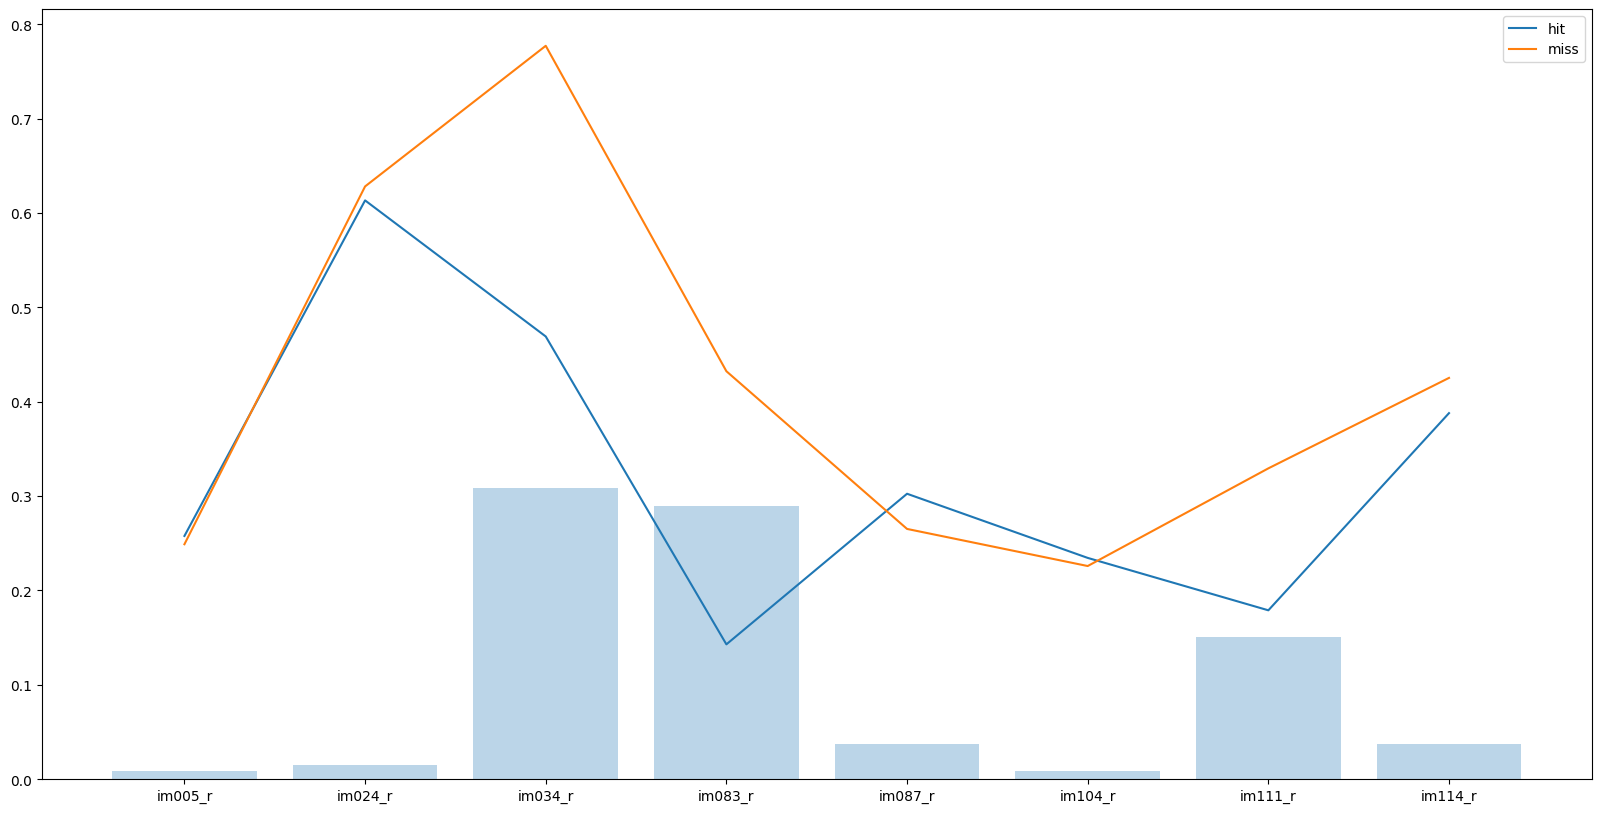

In [ ]:
u = np.zeros(12)
h = np.zeros(12)
m = np.zeros(12)
for idx, img in enumerate(counts_unchanged.keys()):
    #print(img)
    unchanged = counts_unchanged[img]
    unchanged_total = np.sum(list(unchanged.values())) if np.sum(list(unchanged.values())) > 0 else 1e-10
    unchanged_img = np.array(list(unchanged.values()))/unchanged_total
    
    hit = counts_hit[img]
    hit_total = np.sum(list(hit.values())) if np.sum(list(hit.values())) > 0 else 1e-10
    hit_img = np.array(list(hit.values()))/hit_total
    
    miss = counts_miss[img]
    miss_total = np.sum(list(miss.values())) if np.sum(list(miss.values())) > 0 else 1e-10
    miss_img = np.array(list(miss.values()))/miss_total
    
    #u[idx] = np.linalg.norm(unchanged_img)
    h[idx] = np.linalg.norm(unchanged_img - hit_img)
    m[idx] = np.linalg.norm(unchanged_img - miss_img)

plt.figure(figsize=(20,10))
plt.plot(h[:-4], label='hit')
plt.plot(m[:-4], label='miss')
plt.bar(np.arange(0,8), np.abs(h-m)[:-4], alpha=0.3)
#plt.plot(u, label='baseline')

plt.xticks(ticks=np.arange(0,8,1), labels=list(counts_unchanged.keys())[:-2])
plt.legend()

### Pomegranate

In [ ]:
model3 = DenseHMM([ZeroInflated(Poisson()).cuda()]*8, max_iter=100, verbose=True).cuda()
model3.fit(X_train_tensor.cuda()).cuda()

In [ ]:
from pomegranate.distributions import Normal
X3 = torch.randn(100, 50, 2)

X_train_tensor = torch.from_numpy(X_train)
X_train_tensor_reshape = torch.reshape(X_train_tensor, (1, X_train_tensor.shape[0], X_train_tensor.shape[1]))
print(X_train_tensor_reshape.shape)
#arr = X_train_tensor
#X_train_tensor_cat = torch.cat((X_train_tensor, X_train_tensor),0)

print(type(torch.from_numpy(X_train)))
print(torch.isin(0,torch.var(X_train_tensor, dim=1)))
model3 = pomegranate.hmm.DenseHMM([Poisson(), Poisson(), Poisson()], verbose=True)
print(X_train_tensor.shape)
model3.fit([X_train_tensor])



#model3.distributions[0].means, model3.distributions[1].means, model3.distributions[2].means

### Preparing data for rastermap

In [ ]:
start_time = 0
end_time = 3000
bin_size = 50
#spks
X_train = getX(start_time,end_time,bin_size)
#run
running_speed = session.running_speed
timestamp_end = np.where(running_speed['timestamps'] > end_time)[0][0]
timestamps = running_speed['timestamps'][:timestamp_end]
speed = running_speed['speed'][0:timestamp_end]
interp = np.arange(25.50, end_time, bin_size/1000)
padding = np.zeros(len(np.arange(0,25.50,bin_size/1000)))
run = np.interp(interp, timestamps, speed)
run = np.concatenate((padding, run))
#lick
licks = np.array(session.licks['timestamps'])
stop_idx = np.where(licks > end_time)[0][0]
licks = licks[:stop_idx]
licks = licks / (bin_size / 1000)
#store
data = {'run':run, 'spks': X_train, 'licks':licks}
path = "E:/jerry/vbn_s3_cache/visual-behavior-neuropixels-0.5.0/behavior_ecephys_sessions/1064644573/1064644573_0_3000_50_all.npy"
np.save(path, data, allow_pickle=True)

100%|████████████████████████████████████████████████████████████████████████████████| 271/271 [00:07<00:00, 35.59it/s]


### To do

1. tSNE to visualize all the states and add colors for each stimulus
1. Also train Day 1 and compare the transmission matrices
2. Compare differences of the two days
3. Compare how sustained the states are for each stimulus, and compare with each other
